# Detecting Mouse Convulsion Start with DeepLabCut Likelihood Fluctuations

This Notebook aims to automatically detect the onset of convulsions in mice using the DeepLabCut software in video recordings.

The "superanimal_topviewmouse" model, trained on top-down views of mice, is employed for identification. This model outputs per-body-part likelihood scores. It is hypothesized that the violent twitches characteristic of convulsions will cause significant fluctuations in these likelihood scores across consecutive frames, enabling to pinpoint the seizure's start.


Fix to be able to use the Colab's GPU, see: https://github.com/DeepLabCut/DeepLabCut/issues/2465#issuecomment-1862954771

In [ ]:
!apt-get -qq update && apt-get -qq install cuda-11-8

Install DeepLabCut from a personal fork which has a single added line that allows to run the "superanimal_topviewmouse_dlcrnet" model.

In [ ]:
!pip install --quiet -U git+https://github.com/ManuelZ/DeepLabCut@fix_over_238
!pip install --quiet huggingface_hub "tensorflow>=2.0,<=2.10"

Load libraries:

In [ ]:
import deeplabcut
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Loading DLC 2.3.8...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)




Initiate inference on the truncated input video, processing only up to 1 minute and 13 seconds. Truncation is necessary due to corruption at this point, which causes errors during inference.

In [ ]:
superanimal_name = 'superanimal_topviewmouse'
video_path = '/content/cut_out.mp4'
scale_list = range(200, 600, 50)
deeplabcut.video_inference_superanimal([video_path], superanimal_name, scale_list=scale_list, video_adapt=False)

Loading.... superanimal_topviewmouse_dlcrnet


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)k_resnet_50_iteration-0_shuffle-1.tar.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Loading  /content/cut_out.mp4
Duration of video [s]:  73.27 , recorded with  30.0 fps!
Overall # of frames:  2198  found with (before cropping) frame dimensions:  1280 720
Starting to extract posture


  0%|          | 0/2198 [00:00<?, ?it/s]

scale list range(200, 600, 50)


100%|██████████| 2198/2198 [11:26<00:00,  3.20it/s]


Saving results in /content...
Starting to process video: /content/cut_out.mp4
Loading /content/cut_out.mp4 and data.
Duration of video [s]: 73.27, recorded with 30.0 fps!
Overall # of frames: 2198 with cropped frame dimensions: 1280 720
Generating frames and creating video.


100%|██████████| 2198/2198 [00:24<00:00, 89.77it/s]


Prepare utility functions:

In [ ]:
def anomaly_detection(h5_filepath: str, prob_cutoff: float, filter_bodyparts:list[str]):
    """
    Identify the frame with the most different bodyparts' likelihoods between frames in the video
    """

    # The DataFrame columns are MultiIndex columns
    df = pd.read_hdf(h5_filepath)

    # Get unique bodyparts
    bodyparts = df.columns.get_level_values(1).unique()

    # Create a new dataframe with only the likelihood from each bodypart
    new_df = pd.DataFrame({}, columns=bodyparts)
    for col in bodyparts:
        new_col = df.loc[:, ("DLC_snapshot-200000", col, "likelihood")]
        new_df[col] = new_col

    # Filter columns of interest
    new_df = new_df.loc[:, filter_bodyparts]

    # Threshold likelihoods, setting to zero the ones with low confidence
    new_df[new_df < prob_cutoff] = 0

    # Replace NaNs with zeros
    new_df = new_df.fillna(0)

    # Square of the forward difference between frames
    new_df_diff = np.square(new_df.diff())

    # Per-frame mean of the squared differences across all bodyparts
    mean_diffs = new_df_diff.mean(axis=1)

    # Index of the largest mean difference
    idx = mean_diffs.argmax()

    print(f"Frame with the most disruptive change of likelihoods: {idx}")

    # Plot per frame
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(18, 3))
    ax.plot(range(mean_diffs.shape[0]), mean_diffs, linewidth=1)
    ax.set_xlabel("Frame index")
    ax.set_ylabel("Frame score")
    plt.show()

    return idx


def extract_frames(video_path, target_frames):
    """ Extract target frames from a given video """

    video = cv2.VideoCapture(str(video_path))

    if not video.isOpened():
        print("Error opening video file")
        return

    frames = []
    i = 0
    while video.isOpened():
        print(f"Processing frame {str(i).zfill(3)}", end="\r", flush=True)
        ret, frame = video.read()

        # Stop if there was a problem reading a new video frame
        if not ret:
            print(f"Error reading frame {i}", end="\r", flush=True)
            break

        # Skip until arrive to the desired start frame
        if i in target_frames:
            frames.append(frame)

        i += 1

    video.release()

    return frames


def show_images(imgs: list, names: list[str]|None=None):
    """Shows a list of images in a row """

    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(32, 18))
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if names is not None:
            axs[0, i].set_title(names[i])

Frame with the most disruptive change of likelihoods: 83


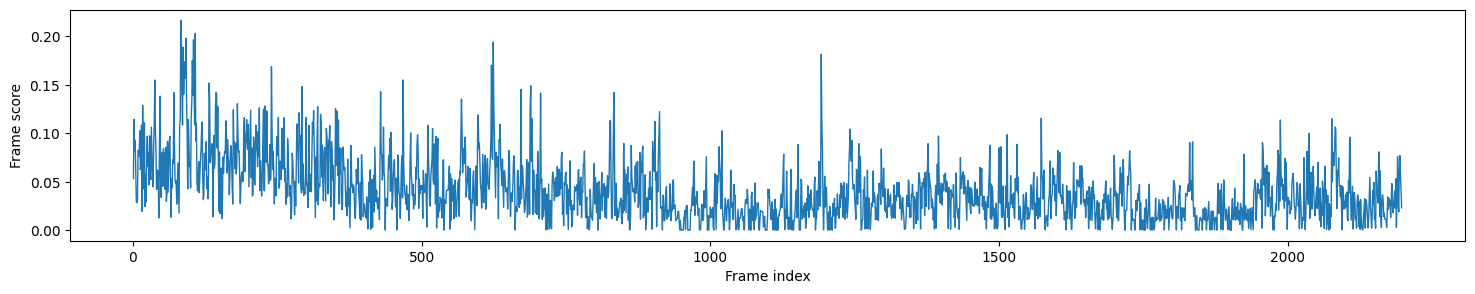

In [ ]:
# All the bodyparts provided by the model. For filtering if needed.
filter_bodyparts = [
    'nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye', 'neck', 'head_midpoint',
    'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3',
    'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'tail_end',
    'left_shoulder', 'right_shoulder',
    'left_midside', 'right_midside',
    'left_hip', 'right_hip',
]

frame_idx = anomaly_detection("/content/cut_outDLC_snapshot-200000.h5", prob_cutoff=0.5, filter_bodyparts=filter_bodyparts)

Display the frames surrounding the frame of interest:

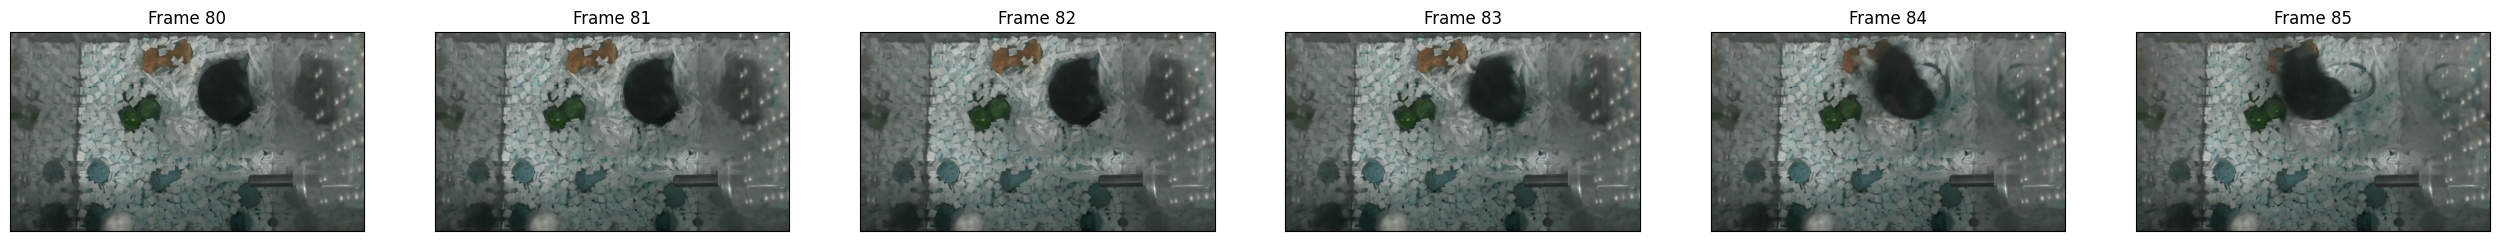

In [ ]:
delta_frames = 3
target_frames_idxs = []
frames_names = []
for f in range(frame_idx-delta_frames, frame_idx+delta_frames):
    target_frames_idxs.append(f)
    frames_names.append(f"Frame {f}")

target_frames = extract_frames(video_path, target_frames_idxs)
show_images(target_frames, frames_names)

The above sequence of images shows three images before and afeter the identified frame of interest. It can be seen that the rat starts convulsing just after this point.